# <center> PTC

### Measurement configuration settings

<hr>
<div class="alert alert-block alert-success">
<b>Remark:</b> Please write the desired values below from the following possibilities: 
    <br> If the parameter is optional, you can write None and it will take a default value
</div>

| Parameter | <p style="text-align: left"> Possible values </p> | Datatype | Comments |
| --- | --- | --- | --- |
| sensor_name | <p style="text-align: left"> 'Mira030', 'Mira050', 'Mira130', 'Mira220' </p> | str | sensor product |
| port | <p style="text-align: left"> 0, 1 </p> | int | CSI port on nvidia 0 is closest to the power supply |
| bit_mode (optional) | <p style="text-align: left"> Mira030: 8bit, 10bit, 12bit <br> Mira050: 8bit, 10bit, 10bithighspeed, 12bit <br> Mira130: 8bit, 10bit <br> Mira220: 8bit, 10bit, 12bit </p> | str | bit depth for a pixel |
| fps (optional) | <p style="text-align: left"> Mira030: 1 - 180 <br> Mira050: 60 <br> Mira130: 30 <br> Mira220: 5 - 90 </p> | float | frame rate |
| w (optional) | <p style="text-align: left"> Mira030: 640 <br> Mira050: 600 <br> Mira130: 1080 <br> Mira220: 1600 </p> | int | width/amount of columns |
| h (optional) | <p style="text-align: left"> Mira030: 480 <br> Mira050: 800 <br> Mira130: 1280 <br> Mira220: 1400 </p> | int | height/amount of rows |
| analog_gain (optional) | <p style="text-align: left"> Mira030: 1- 15.5 <br> Mira050: 1, 2, 4 <br> Mira130: 1 - 28.547 <br> Mira220: 1</p> | int/float | analog gain |
| illum_pcb | <p style="text-align: left"> True, False </p> | bool | 940nm led on the PCB or your own light source |
| roi_process_w | <p style="text-align: left"> smaller than w </p> | int | width/amount of columns to use in calculations |
| roi_process_h | <p style="text-align: left"> smaller than h </p> | int | height/amount of rows to use in calculations |
| guard_banded | <p style="text-align: left"> bigger than 1 </p> | int | extra increase of found saturation exposure time |
| nb_imgs | <p style="text-align: left"> bigger than 0 </p> | int | number of image per exposure step |
| method_exp | <p style="text-align: left"> 'evenly_lin', 'evenly_log', 'multiple_lin' </p> | str | method of distributing the exposure points |
| exp_steps | <p style="text-align: left"> bigger than 0 </p> | int | number of exposure steps between dark and full saturation |
| nb_intervals | <p style="text-align: left"> bigger than 1 </p> | int | number of intervals for distributing the exposure points |
| percentages_intervals | <p style="text-align: left"> [int, int, ...] </p> | list | number of points per interval in percentage for distributing the exposure points |
| points_intervals | <p style="text-align: left"> [int, int, ...]  </p> | list | start and stop points used for the intervals for distributing the exposure points |
| save_notebook_to_html | <p style="text-align: left"> True, False </p> | bool | save notebook outputs an html |
| notebook_name | <p style="text-align: left"> 'plotter_ptc' </p> | str | this notebook name to save to an html |
| save_results_to_excel | <p style="text-align: left"> True, False </p> | bool | save tables to excel (data also present in html) |
| save_images | <p style="text-align: left"> True, False </p> | bool | save taken images to disk |
| grab_new_image_data | <p style="text-align: left"> True, False </p> | bool | perform ptc sweep or use stored dataset |

***

In [1]:
sensor_name = 'Mira220'
port = 0
################################
bit_mode = '12bit'
fps = 30
w = 1600
h = 1400
analog_gain = 1
################################
illum_pcb = True
roi_process_w = 800
roi_process_h = 700
guard_banded = 1.15
nb_imgs = 50
################################
method_exp = 'evenly_lin'
exp_steps = 50
nb_intervals = 2
percentages_intervals = [50, 50]
points_intervals = [0, 20, 100]
################################
save_notebook_to_html = True
notebook_name = 'plotter_ptc'
save_results_to_excel = True
save_images = True
grab_new_image_data = True

### Imports

In [2]:
import numpy as np
import pandas as pd
import time
import os
import sys
import pickle
from tqdm.notebook import tqdm
import plotly.express as px
import plotly.graph_objects as go
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
from datetime import datetime
import h5py

In [3]:
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
sys.path.append(os.path.dirname(os.getcwd()))
from ams_jetcis.scripts import sensor_script_example as scripts
import characterization.stats_engine.stats as stats
import characterization.emva.emva as emva
import characterization.standard_tests.ptc as ptc
import ams_jetcis.scripts.plotter as plotter

### Exposure steps

In [4]:
exp_cfg = scripts.generate_exp_points(method_exp, exp_steps, 
                                      {'nb_intervals':nb_intervals,
                                       'percentages':percentages_intervals, 
                                       'points':points_intervals})

fig = px.scatter(x=exp_cfg, y=np.zeros(len(exp_cfg)), height=200)
fig.update_layout(xaxis=go.layout.XAxis(showticklabels=False), yaxis=go.layout.YAxis(showticklabels=False))
fig.show()

### Get image data

In [8]:
select_sensor_params = {'sensor_name': sensor_name, 'port': port}
init_sensor_params_temp = {'bit_mode' : bit_mode, 'fps' : fps, 'w' : w, 'h' : h, 'analog_gain' : analog_gain}
init_sensor_params = {k: v for k, v in init_sensor_params_temp.items() if v is not None}
sensor = scripts.select_sensor(**select_sensor_params)
sensor.cold_start()
sensor.init_sensor(**init_sensor_params)

Open card:
Current sensor loaded: mira220
Current jetpack loaded: 4.6
Current kernel loaded: Linux-4.9.253-tegra-aarch64-with-Ubuntu-18.04-bionic
Correct sensor driver loaded
Reset sensor low
Reset sensor high 
Mira220 detected with ID 01:0C:2D:05:0B:04:E5:07


In [9]:
datestr = datetime.now().strftime('_%m-%d-%Y_%H%M%S')

In [10]:
if grab_new_image_data:
    # Find saturation exposure
    if illum_pcb:
        scripts.config_illum_trigger_from_exp(sensor, 1e6 / sensor.fps - 5e3)
        currents = [220, 280, 350, 410, 470, 530, 590, 650, 710, 770, 830, 890, 950, 1010]
        for current in currents:
            try:
                sensor.led_driver = [True, current, 1100]
                exp_max = scripts.find_sat_exposure_time(sensor, guard_banded, roi_process_w, roi_process_h)
                break
            except:
                if current == 1010:
                    raise Exception(f'Error: Cannot saturation. Please check your illumination, take a smaller processing ROI or bring your sensor closer to the reflection surface.')
                else:
                    print('Increasing the illumination current...')
        scripts.config_illum_trigger_from_exp(sensor, exp_max)
    else:
        input('Turn on your illumination. Press enter to continue...')
        exp_max = scripts.find_sat_exposure_time(sensor, roi_process_w, roi_process_h)
    print(f'Saturation exposure time [ms]: {exp_max/1e3:.3f}\n')


    # Set exposure time
    exposure_times = exp_cfg / exp_cfg[-1] * exp_max
    exposure_times[0] = sensor.lines_to_time(1)
    print(f'Exposure sweep: {exposure_times}')

    
    # Create hdf5 file to store images and/or data
    results_path = f'{os.getcwd()}/results{datestr}/'
    if not os.path.exists(results_path):
        os.makedirs(results_path)
        
    # Acquire dark series (only 1 implemented)
    print('\nAcquiring dark image series')
    if illum_pcb:
        sensor.led_driver = [False, None, None]
        input('Cover the sensor. Press enter to continue...')
    else:
        input('Turn off your illumination and cover the sensor. Press enter to continue...')

    sensor.exposure_us = exposure_times[0]
    exposure_time_dark_actual = sensor.exposure_us / 1e3
    dark_imgs = sensor.imager.grab_images(nb_imgs)
    dark_imgs = scripts.apply_process_roi(dark_imgs, roi_process_w, roi_process_h)
    data = ptc.get_stats([dark_imgs], pd.DataFrame([exposure_time_dark_actual], columns=['Exposure time [ms]']),
                         rmv_ttn=False, hpf=False)
    
    with h5py.File(results_path + 'ptc.hdf5','w') as h5py_file:
        h5py_file.attrs['Measurement'] = 'PTC'
        h5py_file.create_dataset('dark_imgs', data=dark_imgs, compression='lzf')
    print(f'Dark exposure [ms]: {exposure_time_dark_actual:.3f}, avg [DN]: {np.mean(dark_imgs):.3f}, var [DN]: {stats.total_var_temp(dark_imgs):.3f}')


    # Acquire light series
    print('\nAcquiring grey image series')
    if illum_pcb:
        sensor.led_driver = [True, None, None]
        input('Uncover the sensor. Press enter to continue...')
    else:
        input('Turn on your illumination and uncover the sensor. Press enter to continue...')

    exposure_times_actual = []
    light_avg_imgs = []
    light_ttn_vars = []
    pbar = tqdm(exposure_times)
    for exposure_time in pbar:
        sensor.exposure_us = exposure_time
        exposure_times_actual.append(sensor.exposure_us / 1e3)
        time.sleep(1)

        imgs = sensor.imager.grab_images(nb_imgs)
        imgs = scripts.apply_process_roi(imgs, roi_process_w, roi_process_h)

        light_avg_img = stats.avg_img_stack(imgs)
        light_avg_imgs.append(light_avg_img)

        light_ttn_var = stats.total_var_temp(imgs)
        light_ttn_vars.append(light_ttn_var)

        temp = ptc.get_stats([dark_imgs, imgs], 
                             pd.DataFrame([exposure_time_dark_actual, exposure_times_actual[-1]], 
                                          columns=['Exposure time [ms]']),
                             rmv_ttn=False, hpf=False)
        data = data.append(temp.iloc[1: , :])
        
        if save_images:
            with h5py.File(results_path + 'ptc.hdf5','a') as h5py_file:
                g = h5py_file.create_group(f'EXP_{exposure_times_actual[-1]:.5f}'.replace('.', '_'))
                g.attrs['exposure_time'] = exposure_times_actual[-1]
                g.create_dataset('imgs', data=imgs, compression='lzf')
        
        pbar.set_postfix_str(f'exposure [ms]: {exposure_times_actual[-1]:.3f}, avg [DN]: {np.mean(light_avg_img):.3f}, var [DN]: {light_ttn_var:.3f}')

    data.reset_index(drop=True, inplace=True)
    
    with h5py.File(results_path + 'ptc.hdf5','a') as h5py_file:
        h5py_file.create_dataset('light_avg_imgs', data=light_avg_imgs, compression='lzf')
        h5py_file.create_dataset('light_ttn_vars', data=light_ttn_vars, compression='lzf')
        h5py_file.create_dataset('data', data=data.to_records(index=False), compression='lzf')

    del imgs, light_avg_img
    sensor.led_driver = [False, None, None]
    
else:
    # Load data from hdf5 file
    dir_name = input('Give the directory name. Press enter to continue...')
    with h5py.File(f'{os.getcwd()}/{dir_name}/ptc.hdf5', 'r') as f:
        dark_imgs = np.array(f['dark_imgs'])
        light_avg_imgs = list(f['light_avg_imgs'])
        light_ttn_vars = list(f['light_ttn_vars'])
        data = pd.DataFrame.from_records(f['data'][...])

    # Load images, find exposure name in keys or use exposure from data column
#     with h5py.File(results_path + 'ptc.hdf5', 'r') as f:
#         list(f.keys())
#         np.array(f['EXP_2_45442']['imgs'])

Give the directory name. Press enter to continue...results_01-17-2022_154333


### PTC stats

In [11]:
data, hist, profiles, spect, summ, prnu_img = ptc.ptc_mem_optimized(dark_imgs,
                                                                    light_avg_imgs,
                                                                    light_ttn_vars,
                                                                    data,
                                                                    exp_col='Exposure time [ms]',
                                                                    exp_col_units=['uW/cm^2'])
dark_avg_img = stats.avg_img_stack(dark_imgs)
dark_std_img = np.sqrt(stats.tot_var_img_stack(dark_imgs))

/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:57: FutureWarning:

'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.



ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:57: FutureWarning:

'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.

/home/jetcis/svn/software/trunk/sw/characterization/emva/emva.py:751: RuntimeWarning:

divide by zero encountered in log10

/home/jetcis/svn/software/trunk/sw/characterization/emva/emva.py:829: RuntimeWarning:

divide by zero encountered in log10

/home/jetcis/svn/software/trunk/sw/characterization/emva/emva.py:888: RuntimeWarning:

divide by zero encountered in log10



In [12]:
summ.T

0
System Gain [DN/e]                  0.360395
Conversion Factor [e/DN]            2.774733
Dark Noise [DN]                     2.426612
Dark Noise [e]                      6.733199
Col Temp Noise [e]                  0.899300
Row Temp Noise [e]                  1.409393
Pix Temp Noise [e]                  6.575451
Col DSNU [DN]                       0.369167
Pix DSNU [DN]                       2.089448
Row DSNU [DN]                       0.317492
Total DSNU [DN]                     2.144151
Col DSNU [e]                        1.024340
Pix DSNU [e]                        5.797659
Row DSNU [e]                        0.880956
Total DSNU [e]                      5.949447
Linearity Error Max [%]             1.737877
Linearity Error Max [DN]           15.473452
Linearity Error Min [%]            -2.138216
Linearity Error Min [DN]           -5.192662
Col PRNU1288 [%]                    0.058357
Pix PRNU1288 [%]                    0.515875
Row PRNU1288 [%]                    0.023565
Total PRNU1288 [%]                  0.519377
Responsivity [DN/(['uW/cm^2'])]  1222.665636
Saturation Capacity [e]          9535.073375
Saturation Capacity [DN]         3436.393461
Sensitivity Threshold [e]           7.251739
Sensitivity Threshold [DN]          2.613491
Dynamic Range [ratio]            1314.867225
Dynamic Range [dB]                 62.377638

In [13]:
data

Col Var [DN^2]  Col Temp Var [DN^2]  Mean Signal [DN]  Pix Var [DN^2]  \
0         0.175058             0.105043        209.061608        4.335987   
1         0.161667             0.129341        245.342561        5.470623   
2         0.313934             0.175038        308.822865        7.954211   
3         0.554864             0.189884        383.978690       10.418647   
4         0.894868             0.168489        458.501675       13.004440   
5         1.282353             0.210063        533.054847       16.176032   
6         1.727884             0.259620        609.132463       19.385110   
7         2.315144             0.242544        685.667173       22.998210   
8         2.954204             0.289892        760.465616       27.007718   
9         3.555348             0.341926        836.430699       30.753497   
10        4.328977             0.314791        912.312684       35.305006   
11        5.302731             0.449729        990.015756       40.372402   
12        6.130753             0.394697       1067.561249       44.433039   
13        7.125721             0.430837       1142.158171       49.824605   
14        8.137903             0.503332       1218.252809       55.202989   
15        9.239556             0.606958       1294.654793       60.768411   
16       10.164725             0.629721       1373.284781       66.591203   
17       11.665064             0.781659       1448.307650       72.330427   
18       12.975923             0.877030       1524.001676       77.297698   
19       13.945765             0.895726       1603.079990       85.074651   
20       15.768404             1.136258       1679.913945       88.472470   
21       17.204156             0.663889       1755.969480       95.916564   
22       19.058626             0.766785       1831.588400      101.118966   
23       20.327129             1.141298       1908.557904      109.978938   
24       22.174807             1.271513       1986.339262      115.845435   
25       23.883179             1.109978       2060.615419      124.816786   
26       25.372541             1.480143       2137.203236      130.490641   
27       27.367933             1.481472       2211.366286      138.425236   
28       29.343803             1.678265       2286.585113      147.669746   
29       30.771914             1.550572       2365.101489      155.152562   
30       32.734744             2.033613       2440.052096      163.391608   
31       34.997055             2.491965       2507.426824      171.487508   
32       36.173258             2.258783       2583.321198      174.783638   
33       38.477950             1.168574       2658.058258      185.776173   
34       40.258882             2.502769       2739.366103      193.236241   
35       43.595699             1.961121       2815.441536      200.183692   
36       45.216086             2.004240       2888.932309      210.967597   
37       48.064069             3.092321       2964.308628      216.557890   
38       48.890375             1.956243       3036.018392      227.798973   
39       51.101752             2.724464       3113.575232      238.216309   
40       53.601763             3.512189       3188.710774      247.689054   
41       55.689500             1.541008       3271.191529      256.467632   
42       57.952577             3.689245       3346.539274      268.549022   
43       60.176164             2.475074       3419.528296      283.034310   
44       61.449544             3.638345       3494.530754      287.752407   
45       65.103612             3.912059       3569.452070      298.844703   
46       68.629251             3.213998       3645.455069      306.805074   
47       70.492734             2.863307       3723.158119      314.770442   
48       71.928293             3.515532       3790.479670      322.435172   
49       44.842248             1.782602       3852.979965      207.662340   
50       11.200704             0.218688       3886.552366       19.716344   


### Plot results

In [14]:
fig = px.line(data, x='Signal - Dark [DN]', y=['Tot Temp Var - Tot Dark Temp Var [DN^2]','System Gain Fit [DN^2]'], 
              title='Photon transfer curve (PTC)')
fig.update_xaxes(rangemode="nonnegative")
fig.update_yaxes(rangemode="nonnegative")
fig.show()

In [15]:
fig = px.line(data.iloc[1: , :], x='Exposure time [ms]', y=['Signal - Dark [DN]', 
                                                            'Linearity Fit [DN]', 
                                                            'Responsivity Fit [DN]'], 
              title='Response curve')
fig.update_xaxes(rangemode="nonnegative")
fig.update_yaxes(rangemode="nonnegative")
fig.show()

In [16]:
fig = px.line(data.iloc[1: , :], x='Exposure time [ms]', y='Linearity Error [%]', 
              title='Linearity error')
fig.show()

In [17]:
plotter.histogram(prnu_img, hist['PRNU1288'], 
                  title='PRNU', 
                  unit='DN',
                  nb_limit_std=10)

plotter.accumulated_histogram(prnu_img, hist['PRNU1288'], 
                              title='PRNU', 
                              unit='DN',
                              nb_limit_std=10)

In [18]:
plotter.histogram(dark_avg_img, hist['DSNU1288'], 
                  title='DSNU', 
                  unit='DN',  
                  nb_limit_std=10)

plotter.accumulated_histogram(dark_avg_img, hist['DSNU1288'], 
                              title='DSNU', 
                              unit='DN',  
                              nb_limit_std=10)

In [19]:
hist_tdn = emva.histogram1288(dark_std_img, 256, nb_imgs, black_level=True)

plotter.histogram(dark_std_img, hist_tdn, 
                  title='temporal dark noise', 
                  unit='DN', 
                  nb_limit_std=10)

plotter.accumulated_histogram(dark_std_img, hist_tdn, 
                              title='temporal dark noise', 
                              unit='DN', 
                              nb_limit_std=10)


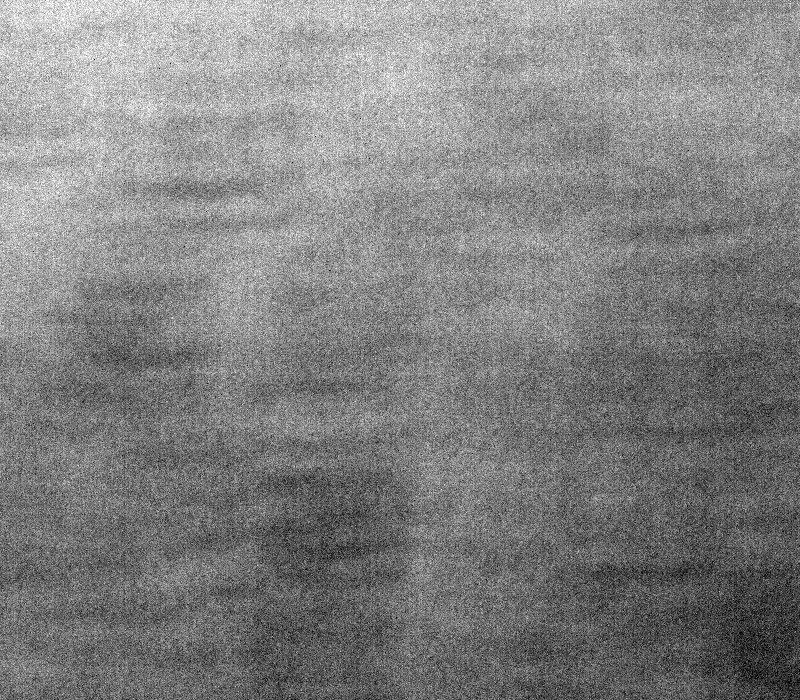

In [20]:
plotter.rowcolumn(prnu_img,
                  np.max([0, (np.median(prnu_img) - 3 * np.std(prnu_img))]), 
                  np.median(prnu_img) + 3 * np.std(prnu_img),
                  title='PRNU')


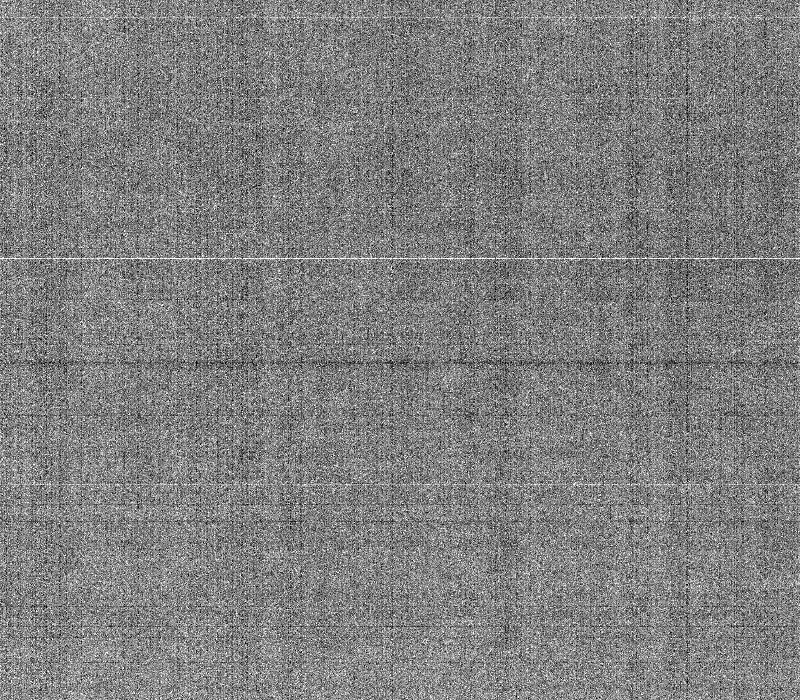

In [21]:
plotter.rowcolumn(dark_avg_img,
                  np.max([0, (np.median(dark_avg_img) - 3 * np.std(dark_avg_img))]), 
                  np.median(dark_avg_img) + 3 * np.std(dark_avg_img),
                  title='DSNU')

In [22]:
plotter.spectrogram(spect['PRNU1288'], 
                    summ['Total PRNU1288 [%]'][0], 
                    'PRNU')

In [23]:
plotter.spectrogram(spect['DSNU1288'], 
                    summ['Total DSNU [DN]'][0], 
                    'DSNU')

In [24]:
plotter.multi_profile(profiles['PRNU1288'],
                      param = 'PRNU',
                      orientation = 'Horizontal')
plotter.multi_profile(profiles['PRNU1288'],
                      param = 'PRNU',
                      orientation = 'Vertical')

In [25]:
plotter.multi_profile(profiles['DSNU1288'],
                      param = 'DSNU',
                      orientation = 'Horizontal')
plotter.multi_profile(profiles['DSNU1288'],
                      param = 'DSNU',
                      orientation = 'Vertical')

In [26]:
plotter.profile(stats.noise_profile(dark_imgs, axis='row'),
                axis='Row', quantity='noise', unit='DN')
plotter.profile(stats.noise_profile(dark_imgs, axis='column'),
                axis='Column', quantity='noise', unit='DN')
plotter.profile(stats.fpn_profile(dark_imgs, axis='row'),
                axis='Row', quantity='FPN', unit='DN')
plotter.profile(stats.fpn_profile(dark_imgs, axis='column'),
                axis='Column', quantity='FPN', unit='DN')

In [27]:
# fig = px.line(data.iloc[1: , :], x='Mean Signal [e]' , y=['SNR [dB]', 'SNR Ideal [dB]', 'SNR Theoretical [dB]'], 
#               title='SNR')
# fig.update_xaxes(type="log")
# fig.show()

In [28]:
temp = pd.DataFrame()
temp['Signal - Dark [DN]'] = data['Signal - Dark [DN]']
temp['Total noise Ratio'] = np.sqrt(data['Tot Temp Var [DN^2]']) / np.sqrt(data['Tot Temp Var [DN^2]'])
temp['Row noise Ratio'] = np.sqrt(data['Row Temp Var [DN^2]']) / np.sqrt(data['Tot Temp Var [DN^2]'])
temp['Column noise Ratio'] = np.sqrt(data['Col Temp Var [DN^2]']) / np.sqrt(data['Tot Temp Var [DN^2]'])
temp['Pixel noise Ratio'] = np.sqrt(data['Pix Temp Var [DN^2]']) / np.sqrt(data['Tot Temp Var [DN^2]'])

fig = px.line(temp.iloc[1: , :], x='Signal - Dark [DN]', y=['Total noise Ratio',  
                                                            'Row noise Ratio', 
                                                            'Column noise Ratio', 
                                                            'Pixel noise Ratio'], 
              title='Noise components ratio')
fig.show()

In [29]:
fig = px.line(data.iloc[1: , :], x='Signal - Dark [DN]', y=['Tot FPN [%]', 'Row FPN [%]', 'Col FPN [%]', 'Pix FPN [%]'], 
              title='FPN components ratio')
fig.show()

### Save data

In [30]:
time.sleep(5)

In [31]:
%%javascript
IPython.notebook.save_checkpoint()
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

In [34]:
time.sleep(5)
# Save notebook to html
if save_notebook_to_html:
    path = os.getcwd() + '/'
    if os.path.exists(f'{path + notebook_name}.ipynb'):
        filename = notebook_name + '_notebook'
        
        results_path = path + f'results{datestr}/'
        if not os.path.exists(results_path):
            os.makedirs(results_path)
            
        !jupyter nbconvert --to html {notebook_name}.ipynb --output {results_path + filename}.html
    else: 
        print('Please provide the correct notebook name!')

[NbConvertApp] Converting notebook plotter_ptc.ipynb to html
[NbConvertApp] Writing 6084137 bytes to /home/jetcis/svn/software/trunk/sw/ams_jetcis/notebooks/results_01-17-2022_161621/plotter_ptc_notebook.html


In [33]:
# save results to excel
if save_results_to_excel:
    filename = notebook_name + '_excel'
    
    path = os.getcwd() + '/'
    results_path = path + f'results{datestr}/'
    if not os.path.exists(results_path):
        os.makedirs(results_path)
    
    with pd.ExcelWriter(f'{results_path + filename}.xlsx') as writer:  
        data.to_excel(writer, sheet_name='data')
        
        summ.to_excel(writer, sheet_name='summ')
        
        hist_DSNU = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in hist['DSNU1288'].items()]))
        hist_DSNU.to_excel(writer, sheet_name='hist_DSNU')
        
        hist_PRNU = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in hist['PRNU1288'].items()]))
        hist_PRNU.to_excel(writer, sheet_name='hist_PRNU')
        
        hist_TDN = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in hist_tdn.items()]))
        hist_TDN.to_excel(writer, sheet_name='hist_TDN')
        
        profiles_DSNU = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in profiles['DSNU1288'].items()]))
        profiles_DSNU.to_excel(writer, sheet_name='profiles_DSNU')
        
        profiles_PRNU = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in profiles['PRNU1288'].items()]))
        profiles_PRNU.to_excel(writer, sheet_name='profiles_PRNU')
        
        spect_DSNU = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in spect['DSNU1288'].items()]))
        spect_DSNU.to_excel(writer, sheet_name='spect_DSNU')
        
        spect_PRNU = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in spect['PRNU1288'].items()]))
        spect_PRNU.to_excel(writer, sheet_name='spect_PRNU')